Third Model (Final)

In [2]:
import csv
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, mutual_info_regression


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import pmdarima as pm
from sklearn.feature_selection import RFECV


In [3]:
def plot_train_predict(train_data, predict_data, column_name, save_path=None):
    """
    Plots train data in orange and prediction data in blue.
    
    Args:
        train_data (pd.DataFrame): Training data with datetime index.
        predict_data (pd.DataFrame): Prediction data with datetime index.
        column_name (str): The column name to plot.
        save_path (str): The path to save the plot. If None, the plot is not saved.
    """
    plt.figure(figsize=(12, 6))
    
    plt.plot(train_data['datetime'], train_data[column_name], color='orange', label='Train Data')
    
    plt.plot(predict_data['datetime'], predict_data[column_name], color='blue', label='Predict Data')
    
    plt.title(f'{column_name} - Train and Predict Data')
    plt.xlabel('Datetime')
    plt.ylabel(column_name)
    
    plt.xticks(rotation=45)
    
    plt.legend()
    
    
    plt.tight_layout()
    plt.show()
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


I will add lagged data later

In [4]:
df = pd.read_csv('energy_data.csv')

df = df.dropna(subset=['energy'])

# Remove rows with negative power
df = df[df['power'] >= 0]
# Aggregate power and energy by datetime
data = df.groupby('datetime').agg({'power': 'sum', 'energy': 'sum'}).reset_index()
raw_data = df.groupby('datetime').agg({'power': 'sum', 'energy': 'sum'}).reset_index()

# Convert datetime column to datetime type
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)
#resample by hour
data = data.resample('h').mean()
data.reset_index(inplace = True)
# Convert datetime back to string format
data['datetime'] = data['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
# Convert DataFrame to dictionary
data_dict = data.to_dict(orient='list')

#Introducing weather
weather_data = {}
with open('weather.csv', mode='r') as weather_file:
    weather_reader = csv.DictReader(weather_file)
    for row in weather_reader:
        weather_data[row['time']] = [row['temperature_2m (°C)'],row['relative_humidity_2m (%)'],row['rain (mm)']]

#Adding weather parameters to dataframe
data_dict['temperature'] = []
data_dict['rh'] = []
data_dict['rain'] = []

for row in data_dict['datetime']:
    date,time = row.split(' ')
    hour,minute,second = time.split(':')
    new_time = date + 'T' + hour + ':00'
    data_dict['temperature'].append(weather_data[new_time][0])
    data_dict['rh'].append(weather_data[new_time][1])
    data_dict['rain'].append(weather_data[new_time][2])

data = pd.DataFrame(data_dict)
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.dropna()

print(data)

                datetime     power      energy temperature  rh  rain
0    2022-07-20 21:00:00  0.455941    0.107882        26.7  90  5.80
1    2022-07-20 22:00:00  0.923787    0.582733        25.9  91  4.60
2    2022-07-20 23:00:00  0.246080    0.513520        25.8  92  2.40
3    2022-07-21 00:00:00  0.179117    0.743867        25.7  92  1.10
4    2022-07-21 01:00:00  0.139763    0.921559        25.8  91  1.80
...                  ...       ...         ...         ...  ..   ...
3715 2022-12-22 16:00:00  0.492374  883.909574        27.8  74  0.00
3716 2022-12-22 17:00:00  0.496741  897.806241        27.2  77  0.00
3717 2022-12-22 18:00:00  0.285893  569.303693        25.2  89  0.00
3718 2022-12-22 19:00:00  0.207950  890.100485        24.4  86  0.00
3719 2022-12-22 20:00:00  0.085027  852.168703        24.7  83  0.00

[3114 rows x 6 columns]


INPUTTING MORE DATA

In [5]:
with open('weather_full.csv', mode='r') as weather_file:
    weather_reader = csv.DictReader(weather_file)
    #[temperature, rh, rain, dew_point, apparent_temp, precipitation, cloud_cover, wind_speed]
    for row in weather_reader:
        weather_data[row['time']].append(row['dew_point_2m (°C)'])
        weather_data[row['time']].append(row['apparent_temperature (°C)'])
        weather_data[row['time']].append(row['precipitation (mm)'])
        weather_data[row['time']].append(row['cloud_cover (%)'])
        weather_data[row['time']].append(row['wind_speed_10m (km/h)'])
        
data['datetime'] = data['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')

data_dict = data.to_dict(orient='list')
data_dict['dew_point'] = []
data_dict['apparent_temp'] = []
data_dict['precipitation'] = []
data_dict['cloud_cover'] = []
data_dict['wind_speed'] = []

for row in data_dict['datetime']:
    date,time = row.split(' ')
    hour,minute,second = time.split(':')
    new_time = date + 'T' + hour + ':00'
    data_dict['dew_point'].append(weather_data[new_time][3])
    data_dict['apparent_temp'].append(weather_data[new_time][4])
    data_dict['precipitation'].append(weather_data[new_time][5])
    data_dict['cloud_cover'].append(weather_data[new_time][6])
    data_dict['wind_speed'].append(weather_data[new_time][7])
data = pd.DataFrame(data_dict)
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.dropna()



Creating time parameters

In [6]:
data['hour_of_day'] = data['datetime'].dt.hour
data["day_of_week"] = data["datetime"].dt.dayofweek
data["month"] = data["datetime"].dt.month
data['day_of_month'] = data['datetime'].dt.day
data['week_of_year'] = data['datetime'].dt.isocalendar().week
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(float)
data['day_of_year'] = data['datetime'].dt.dayofyear
print(data)




                datetime     power      energy temperature  rh  rain  \
0    2022-07-20 21:00:00  0.455941    0.107882        26.7  90  5.80   
1    2022-07-20 22:00:00  0.923787    0.582733        25.9  91  4.60   
2    2022-07-20 23:00:00  0.246080    0.513520        25.8  92  2.40   
3    2022-07-21 00:00:00  0.179117    0.743867        25.7  92  1.10   
4    2022-07-21 01:00:00  0.139763    0.921559        25.8  91  1.80   
...                  ...       ...         ...         ...  ..   ...   
3109 2022-12-22 16:00:00  0.492374  883.909574        27.8  74  0.00   
3110 2022-12-22 17:00:00  0.496741  897.806241        27.2  77  0.00   
3111 2022-12-22 18:00:00  0.285893  569.303693        25.2  89  0.00   
3112 2022-12-22 19:00:00  0.207950  890.100485        24.4  86  0.00   
3113 2022-12-22 20:00:00  0.085027  852.168703        24.7  83  0.00   

     dew_point apparent_temp precipitation cloud_cover wind_speed  \
0         25.0          32.0          5.80         100       10.1 

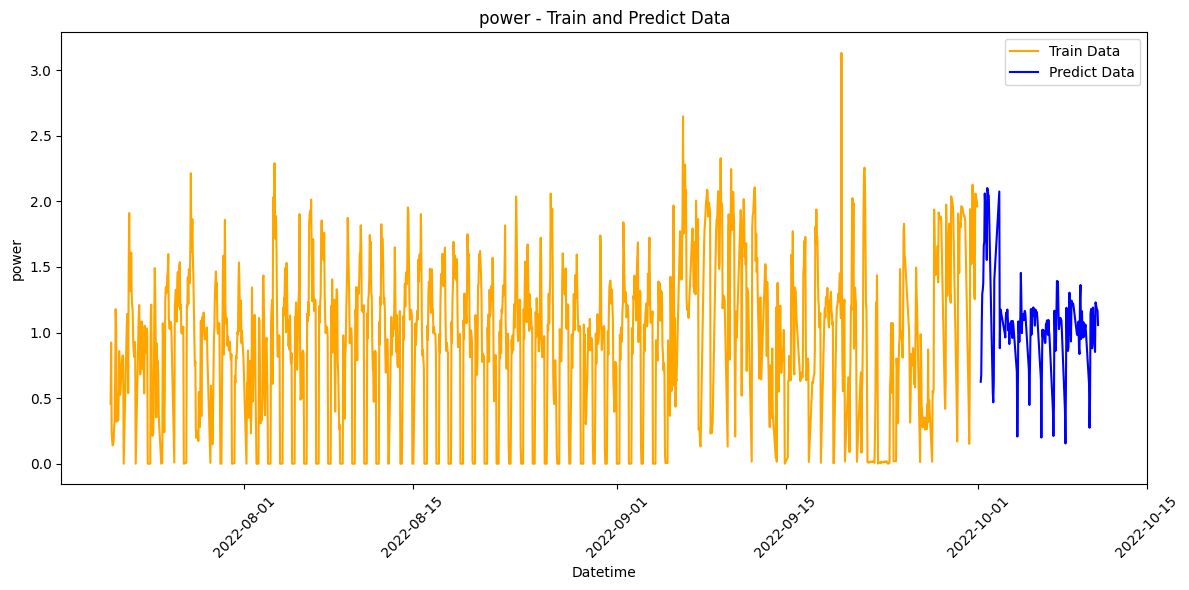

In [7]:
data = data.dropna()
train_data = data[data['datetime'] < '2022-10-01']
predict_data = data[data['datetime'] >= '2022-10-01']
predict_data = predict_data[predict_data['datetime'] < '2022-10-11']
plot_train_predict(train_data, predict_data, 'power', save_path='train_predict_power.png')

Feature Importance (No Lagged Data)

In [8]:
x_train = train_data[[col for col in train_data.columns if col not in ['datetime','energy','power']]]
x_test = predict_data[[col for col in train_data.columns if col not in ['datetime','energy','power']]]

rf = RandomForestRegressor(n_estimators=600,random_state=0,bootstrap=True)
null_rows = data.loc[data.isnull().any(axis=1)]
print(null_rows)
rf.fit(x_train,train_data['power'])


Empty DataFrame
Columns: [datetime, power, energy, temperature, rh, rain, dew_point, apparent_temp, precipitation, cloud_cover, wind_speed, hour_of_day, day_of_week, month, day_of_month, week_of_year, is_weekend, day_of_year]
Index: []


RandomForestRegressor(n_estimators=600, random_state=0)

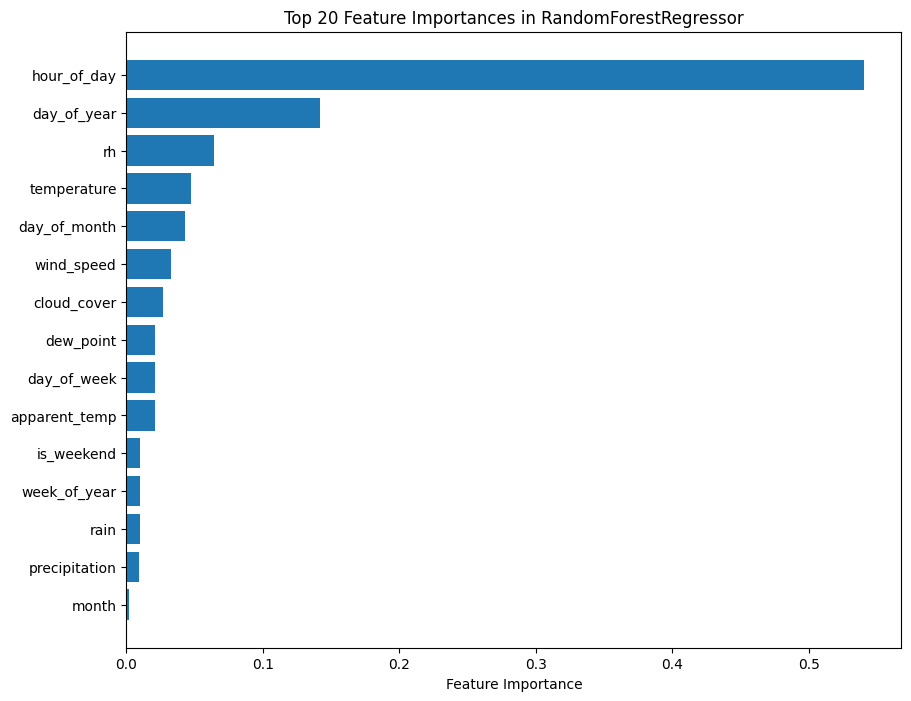

In [9]:
importances = rf.feature_importances_
# Define feature names (from the columns used in x_train)
feature_names = x_train.columns

feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_20_features = feature_imp_df.sort_values('Importance', ascending=False).head(20)
top_10_features = feature_imp_df.sort_values('Importance', ascending=False).head(10)
top_6_features = feature_imp_df.sort_values('Importance', ascending=False).head(6)
top_5_features = feature_imp_df.sort_values('Importance', ascending=False).head(5)

# Plot the top 20 features
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['Feature'], top_20_features['Importance'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances in RandomForestRegressor')
plt.gca().invert_yaxis() 
plt.show()

Creating Lag and Average

In [10]:
#[temperature, rh, rain, dew_point, apparent_temp, precipitation, cloud_cover, wind_speed]
warnings.filterwarnings("ignore")
def convert_columns_to_float(df):
    df = df.copy()
    cols_to_convert = df.columns.difference(['datetime'])
    df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')
    return df
temp = {'temperature': 0, 'rh':1,'rain' : 2, "dew_point" : 3, "apparent_temp":4, "precipitation":5, "cloud_cover":6, "wind_speed":7}

#cutoff_date = pd.to_datetime('2022-12-19')

def create_lagged_features(df, columns, lags):
    df = df.copy()
    for col in columns:
        for lag in range(1, lags + 1):
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
    for col in columns:
        if col == 'power':
            continue
        for lag in range(1,lag+1):
            for k in range(lag):
                df.loc[k,f'{col}_lag{lag}'] = weather_data[(df.loc[k,'datetime']- pd.DateOffset(hours=lag)).strftime('%Y-%m-%dT%H:00')][temp[col]]
    return df
def calculate_rolling_averages(df, columns, lags):
    df = df.copy()
    
    for col in columns:
        for lag in range(2, lags + 1):
            lag_cols = [f'{col}_lag{i+1}' for i in range(lag)]
            df[f'average_{col}_{lag}'] = df[lag_cols].mean(axis=1 ,skipna=False)
    
    return df
data['datetime'] = pd.to_datetime(data['datetime'])
data = create_lagged_features(data, ['temperature','rh','rain','dew_point','apparent_temp','precipitation','cloud_cover','wind_speed'], 24)
data = convert_columns_to_float(data)
data = calculate_rolling_averages(data, ['temperature','rh','rain','dew_point','apparent_temp','precipitation','cloud_cover','wind_speed'],24)



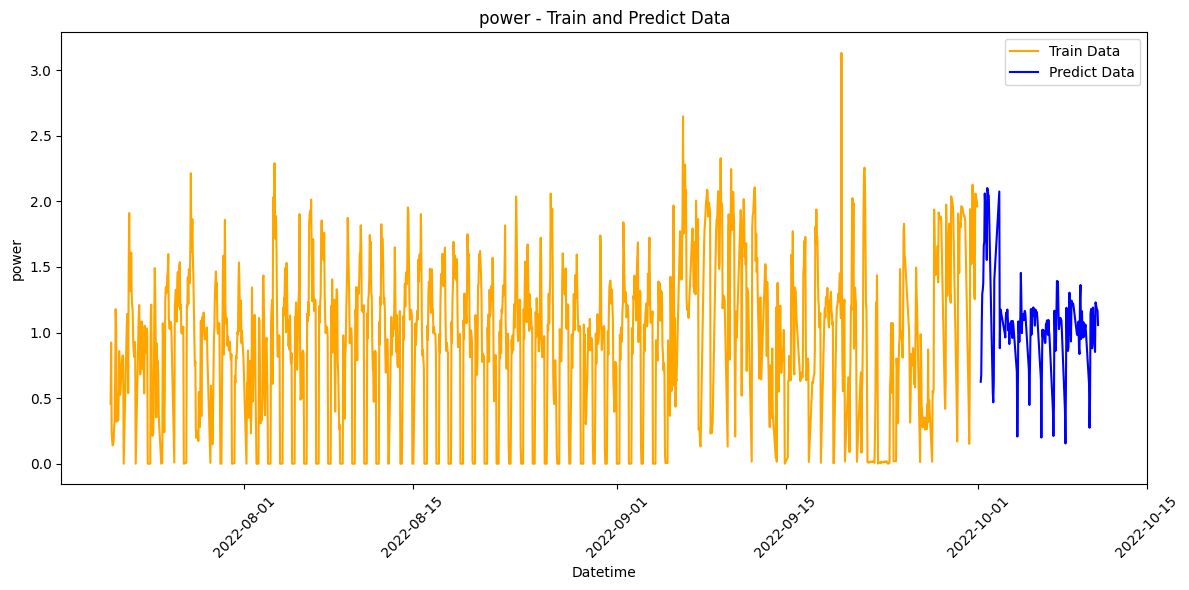

In [11]:
data = data.dropna()
train_data = data[data['datetime'] < '2022-10-01']
predict_data = data[data['datetime'] >= '2022-10-01']
predict_data = predict_data[predict_data['datetime'] < '2022-10-11']
plot_train_predict(train_data, predict_data, 'power', save_path='train_predict_power.png')

Feature Importance (With Lagged data)

In [12]:
x_train = train_data[[col for col in train_data.columns if col not in ['datetime','energy','power']]]
x_test = predict_data[[col for col in train_data.columns if col not in ['datetime','energy','power']]]
rf = RandomForestRegressor(n_estimators=600,random_state=0,bootstrap=True)
null_rows = data.loc[data.isnull().any(axis=1)]
print(null_rows)
rf.fit(x_train, train_data['power'])

Empty DataFrame
Columns: [datetime, power, energy, temperature, rh, rain, dew_point, apparent_temp, precipitation, cloud_cover, wind_speed, hour_of_day, day_of_week, month, day_of_month, week_of_year, is_weekend, day_of_year, temperature_lag1, temperature_lag2, temperature_lag3, temperature_lag4, temperature_lag5, temperature_lag6, temperature_lag7, temperature_lag8, temperature_lag9, temperature_lag10, temperature_lag11, temperature_lag12, temperature_lag13, temperature_lag14, temperature_lag15, temperature_lag16, temperature_lag17, temperature_lag18, temperature_lag19, temperature_lag20, temperature_lag21, temperature_lag22, temperature_lag23, temperature_lag24, rh_lag1, rh_lag2, rh_lag3, rh_lag4, rh_lag5, rh_lag6, rh_lag7, rh_lag8, rh_lag9, rh_lag10, rh_lag11, rh_lag12, rh_lag13, rh_lag14, rh_lag15, rh_lag16, rh_lag17, rh_lag18, rh_lag19, rh_lag20, rh_lag21, rh_lag22, rh_lag23, rh_lag24, rain_lag1, rain_lag2, rain_lag3, rain_lag4, rain_lag5, rain_lag6, rain_lag7, rain_lag8, rain_lag

RandomForestRegressor(n_estimators=600, random_state=0)

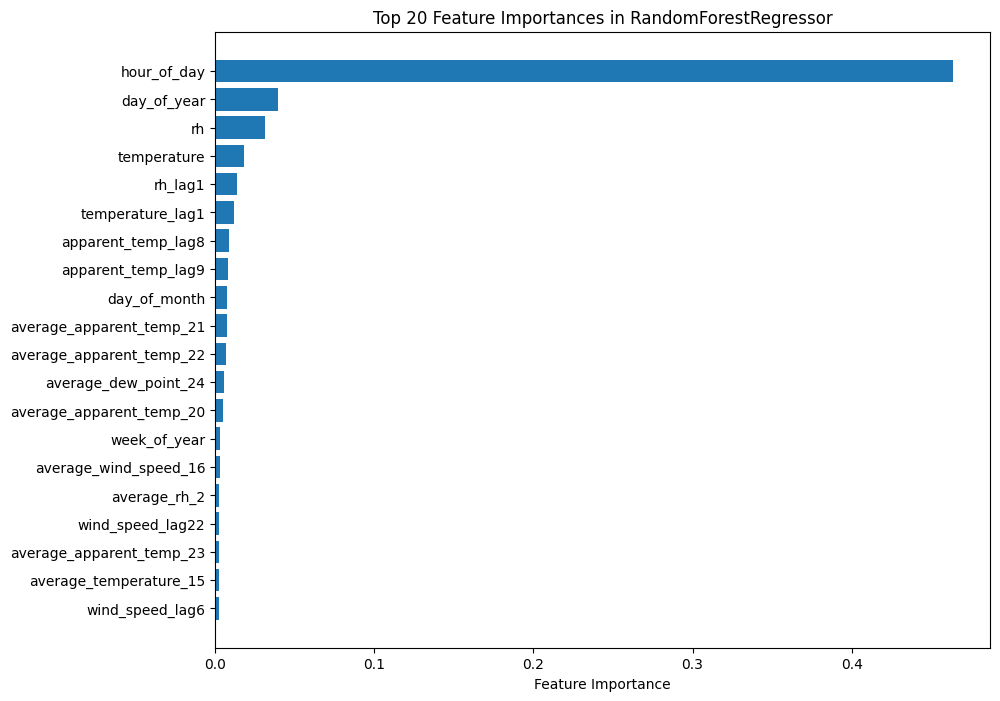

In [14]:
importances = rf.feature_importances_
# Define feature names (from the columns used in x_train)
feature_names = x_train.columns

feature_imp_df_with_lag = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_20_features_lag = feature_imp_df_with_lag.sort_values('Importance', ascending=False).head(20)
top_12_features_lag = feature_imp_df_with_lag.sort_values('Importance', ascending=False).head(12)
# Plot the top 20 features
plt.figure(figsize=(10, 8))
plt.barh(top_20_features_lag['Feature'], top_20_features_lag['Importance'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances in RandomForestRegressor')
plt.gca().invert_yaxis()  
plt.show()

Linear Regression (No lag)

In [15]:
X = train_data[top_6_features['Feature'].values]
Y = train_data['power']
regr = linear_model.LinearRegression()
regr.fit(X, Y)

coefficients = regr.coef_ 
intercept = regr.intercept_ 

print("Coefficients:", coefficients)
print("Intercept:", intercept)


Coefficients: [ 0.01430813  0.00544862 -0.02373687  0.0379111  -0.00212166  0.0117393 ]
Intercept: 0.3017952790900015


Mean Squared Error(Recursive): 0.07651686701743118


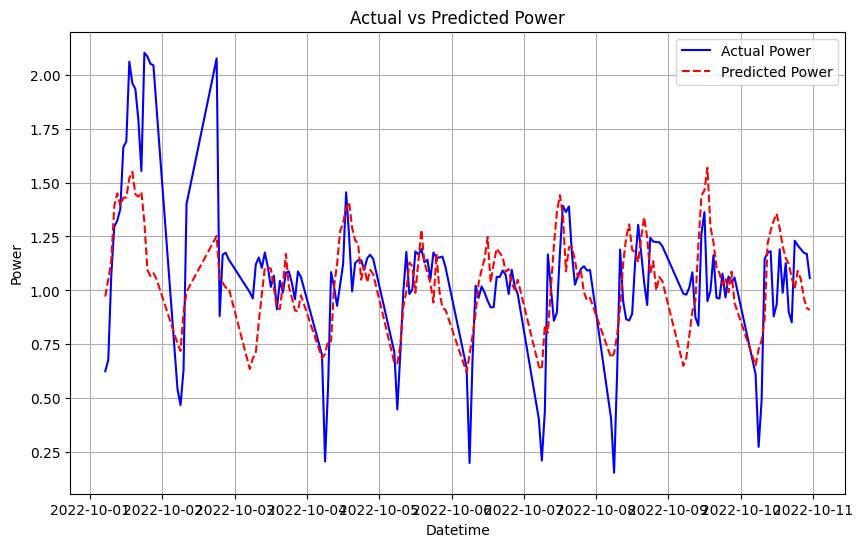

In [16]:

predict_data['predicted_power'] = regr.predict(predict_data[top_6_features['Feature'].values])
mse = mean_squared_error(predict_data['power'], predict_data['predicted_power'])
print(f'Mean Squared Error(Recursive): {mse}')

plt.figure(figsize=(10, 6))
plt.plot(predict_data['datetime'], predict_data['power'], label='Actual Power', color='blue')
plt.plot(predict_data['datetime'], predict_data['predicted_power'], label='Predicted Power', color='red', linestyle='--')
plt.xlabel('Datetime')
plt.ylabel('Power')
plt.title('Actual vs Predicted Power')
plt.legend()
plt.grid(True)
plt.show()

Linear Regression (With Lag)

In [17]:
X = train_data[top_12_features_lag['Feature'].values]
Y = train_data['power']
regr = linear_model.LinearRegression()
regr.fit(X, Y)

coefficients = regr.coef_  
intercept = regr.intercept_  

print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [ 0.01675372  0.00422971 -0.00975605  0.1056313  -0.01119747 -0.05941467
 -0.01127751 -0.03703058 -0.0020413  -0.29249567  0.27917518  0.02106492]
Intercept: 1.7307003534552778


Mean Squared Error(Recursive): 0.09131293481123777


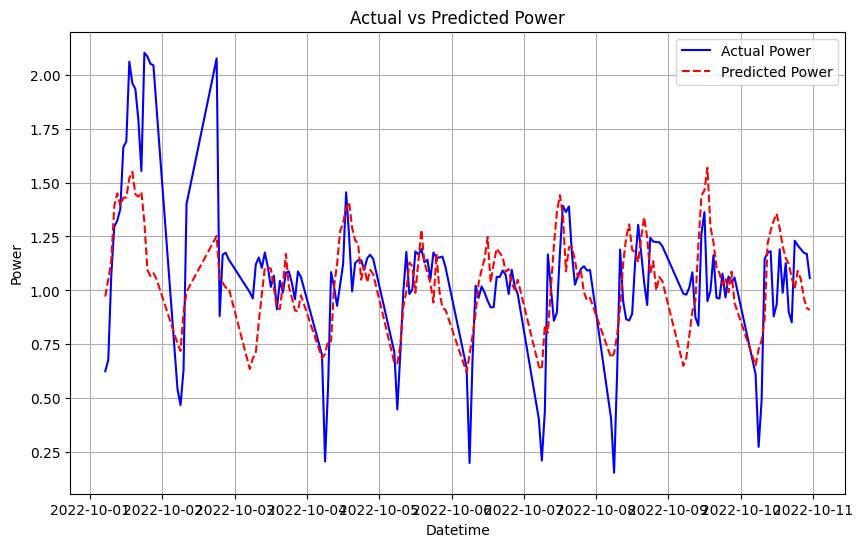

In [18]:

predict_data['predicted_power_lag'] = regr.predict(predict_data[top_12_features_lag['Feature'].values])
mse = mean_squared_error(predict_data['power'], predict_data['predicted_power_lag'])
print(f'Mean Squared Error(Recursive): {mse}')

plt.figure(figsize=(10, 6))
plt.plot(predict_data['datetime'], predict_data['power'], label='Actual Power', color='blue')
plt.plot(predict_data['datetime'], predict_data['predicted_power'], label='Predicted Power', color='red', linestyle='--')
plt.xlabel('Datetime')
plt.ylabel('Power')
plt.title('Actual vs Predicted Power')
plt.legend()
plt.grid(True)
plt.show()

Ridge Regression

In [19]:
from sklearn.linear_model import Ridge
X = train_data[top_6_features['Feature'].values]
Y = train_data['power']
regr = Ridge()
regr.fit(X, Y)

coefficients = regr.coef_  
intercept = regr.intercept_  

print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [ 0.01430911  0.00544815 -0.02374617  0.03786101 -0.00212149  0.01173758]
Intercept: 0.3040625859241515


Mean Squared Error(Recursive): 0.07652089587677749


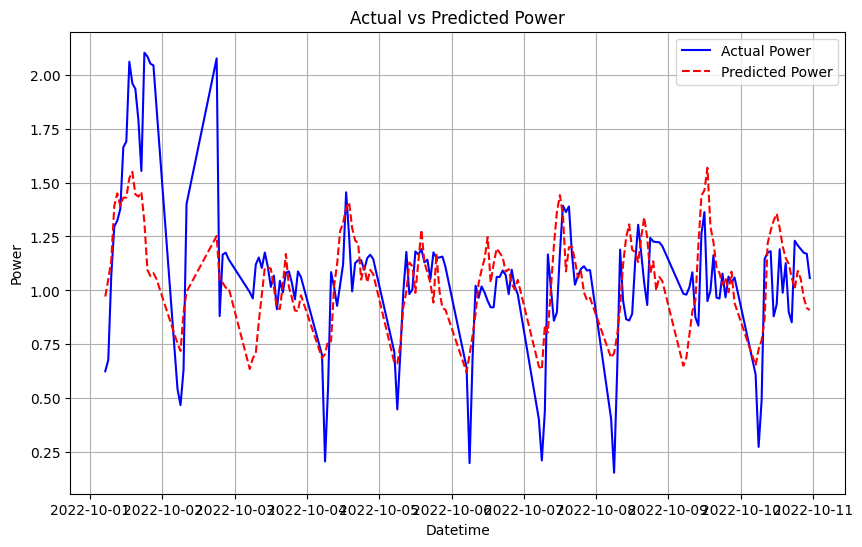

In [20]:

predict_data['predicted_power_ridge'] = regr.predict(predict_data[top_6_features['Feature'].values])
mse = mean_squared_error(predict_data['power'], predict_data['predicted_power_ridge'])
print(f'Mean Squared Error(Recursive): {mse}')

plt.figure(figsize=(10, 6))
plt.plot(predict_data['datetime'], predict_data['power'], label='Actual Power', color='blue')
plt.plot(predict_data['datetime'], predict_data['predicted_power_ridge'], label='Predicted Power', color='red', linestyle='--')
plt.xlabel('Datetime')
plt.ylabel('Power')
plt.title('Actual vs Predicted Power')
plt.legend()
plt.grid(True)
plt.show()

Lasso Regression

Mean Squared Error(Recursive): 0.0902652571722514


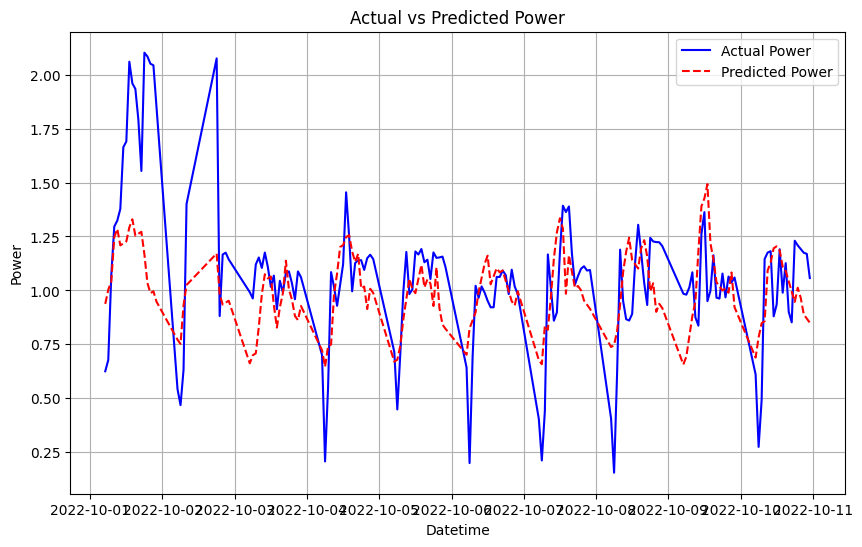

In [21]:
from sklearn.linear_model import Lasso

regr = Lasso(alpha=0.3)
regr.fit(X,Y)
predict_data['predicted_power_lasso'] = regr.predict(predict_data[top_6_features['Feature'].values])
mse = mean_squared_error(predict_data['power'], predict_data['predicted_power_lasso'])
print(f'Mean Squared Error(Recursive): {mse}')

plt.figure(figsize=(10, 6))
plt.plot(predict_data['datetime'], predict_data['power'], label='Actual Power', color='blue')
plt.plot(predict_data['datetime'], predict_data['predicted_power_lasso'], label='Predicted Power', color='red', linestyle='--')
plt.xlabel('Datetime')
plt.ylabel('Power')
plt.title('Actual vs Predicted Power')
plt.legend()
plt.grid(True)
plt.show()

Applying Train_test_split

In [22]:
cutoff_date = pd.to_datetime('2022-10-11')

new_data = data[data['datetime']< cutoff_date].copy()

In [23]:
X = new_data[[col for col in new_data.columns if col not in ['datetime','energy','power']]]
Y = new_data[['power']]

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


Feature Importance (Train test split)

In [25]:

rf = RandomForestRegressor(n_estimators=600,random_state=0,bootstrap=True)
null_rows = data.loc[data.isnull().any(axis=1)]
print(null_rows)
rf.fit(X_train,y_train)

Empty DataFrame
Columns: [datetime, power, energy, temperature, rh, rain, dew_point, apparent_temp, precipitation, cloud_cover, wind_speed, hour_of_day, day_of_week, month, day_of_month, week_of_year, is_weekend, day_of_year, temperature_lag1, temperature_lag2, temperature_lag3, temperature_lag4, temperature_lag5, temperature_lag6, temperature_lag7, temperature_lag8, temperature_lag9, temperature_lag10, temperature_lag11, temperature_lag12, temperature_lag13, temperature_lag14, temperature_lag15, temperature_lag16, temperature_lag17, temperature_lag18, temperature_lag19, temperature_lag20, temperature_lag21, temperature_lag22, temperature_lag23, temperature_lag24, rh_lag1, rh_lag2, rh_lag3, rh_lag4, rh_lag5, rh_lag6, rh_lag7, rh_lag8, rh_lag9, rh_lag10, rh_lag11, rh_lag12, rh_lag13, rh_lag14, rh_lag15, rh_lag16, rh_lag17, rh_lag18, rh_lag19, rh_lag20, rh_lag21, rh_lag22, rh_lag23, rh_lag24, rain_lag1, rain_lag2, rain_lag3, rain_lag4, rain_lag5, rain_lag6, rain_lag7, rain_lag8, rain_lag

RandomForestRegressor(n_estimators=600, random_state=0)

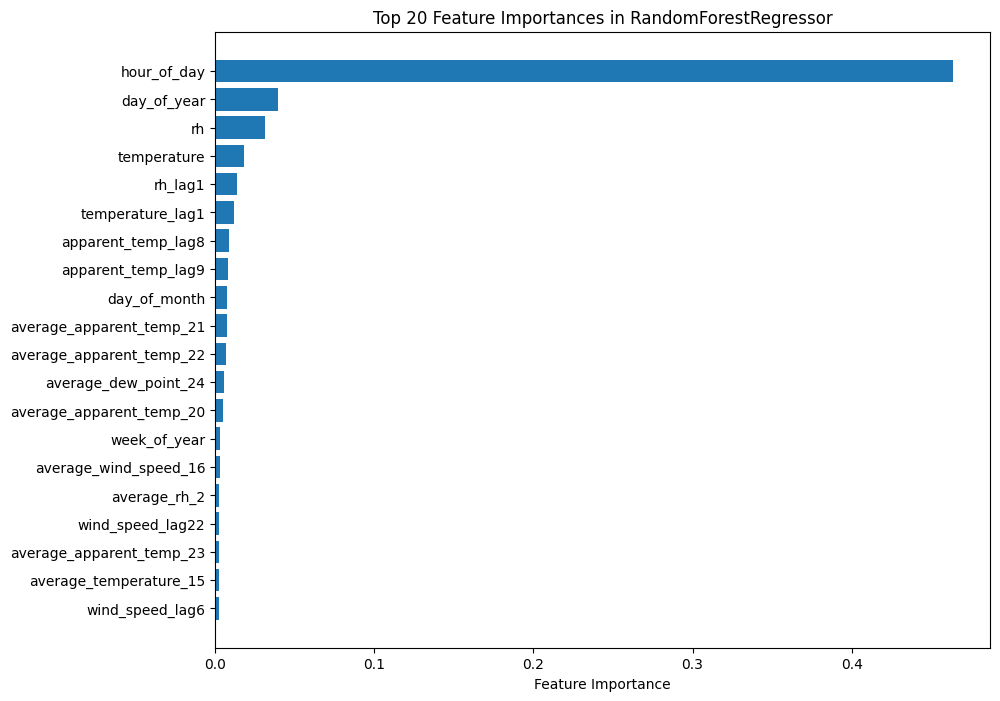

In [27]:
importances = rf.feature_importances_
# Define feature names (from the columns used in x_train)
feature_names = X_train.columns

feature_imp_df_with_lag2 = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_20_features_lag2 = feature_imp_df_with_lag2.sort_values('Importance', ascending=False).head(20)
top_12_features_lag2 = feature_imp_df_with_lag2.sort_values('Importance', ascending=False).head(12)
# Plot the top 20 features
plt.figure(figsize=(10, 8))
plt.barh(top_20_features_lag['Feature'], top_20_features_lag['Importance'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances in RandomForestRegressor')
plt.gca().invert_yaxis()  
plt.show()

XGBOOST

Cut off date (No lag)

In [28]:

def prepare_data(df, feature_columns, target_column):
    # Select features
    X = df[feature_columns].astype(float)
    # Select target
    Y = df[target_column].astype(float)
    # Convert to list
    X_list = X.values.tolist()
    Y_list = Y.values.tolist()
    return X_list, Y_list
feature_columns = top_10_features['Feature'].values
target = 'power'
X, Y = prepare_data(train_data, feature_columns, target)
pred_X, pred_Y = prepare_data(predict_data,feature_columns,target)


In [29]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

cv_split = TimeSeriesSplit(n_splits=4, test_size=80)
model = xgb.XGBRegressor()
parameters = {
    "max_depth": [3, 4, 6, 10],
    "eta": [0.01, 0.05, 0.1, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7],
    "subsample":[0.8,0.9,1.0],
    "gamma": [0,0.2,0.4,0.6]
}

grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters,n_jobs = -1)
grid_search.fit(X, Y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=80),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impor...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'eta': [0.01, 0.05, 0.1, 0.3],
                         'gamma': [0, 0.2, 0.4, 0.6],
                         'max_depth': [3, 4, 6, 10],
                         'n_estimators': [100, 300, 500, 700, 900, 1000],
                         'subsample': [0.8, 0.9, 1.0]})

Mean Squared Error: 0.20453899409580442
Mean Absolute Error: 0.36226403885605446


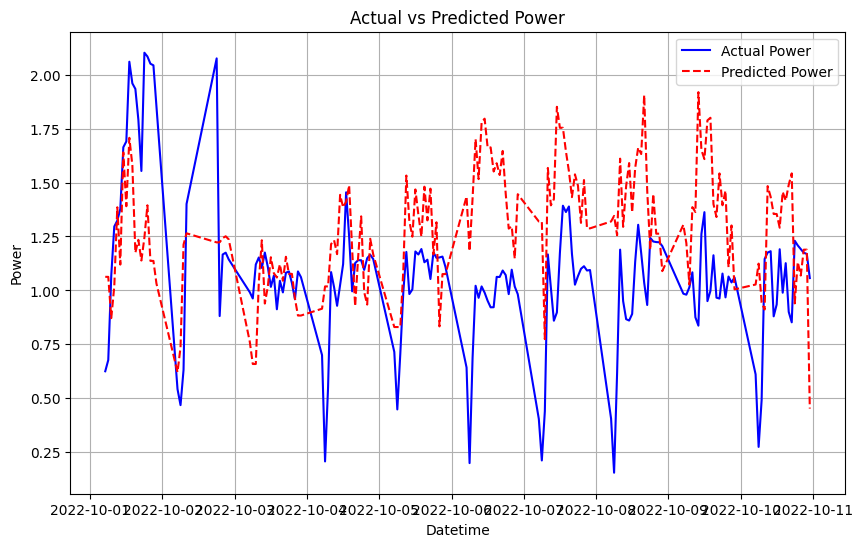

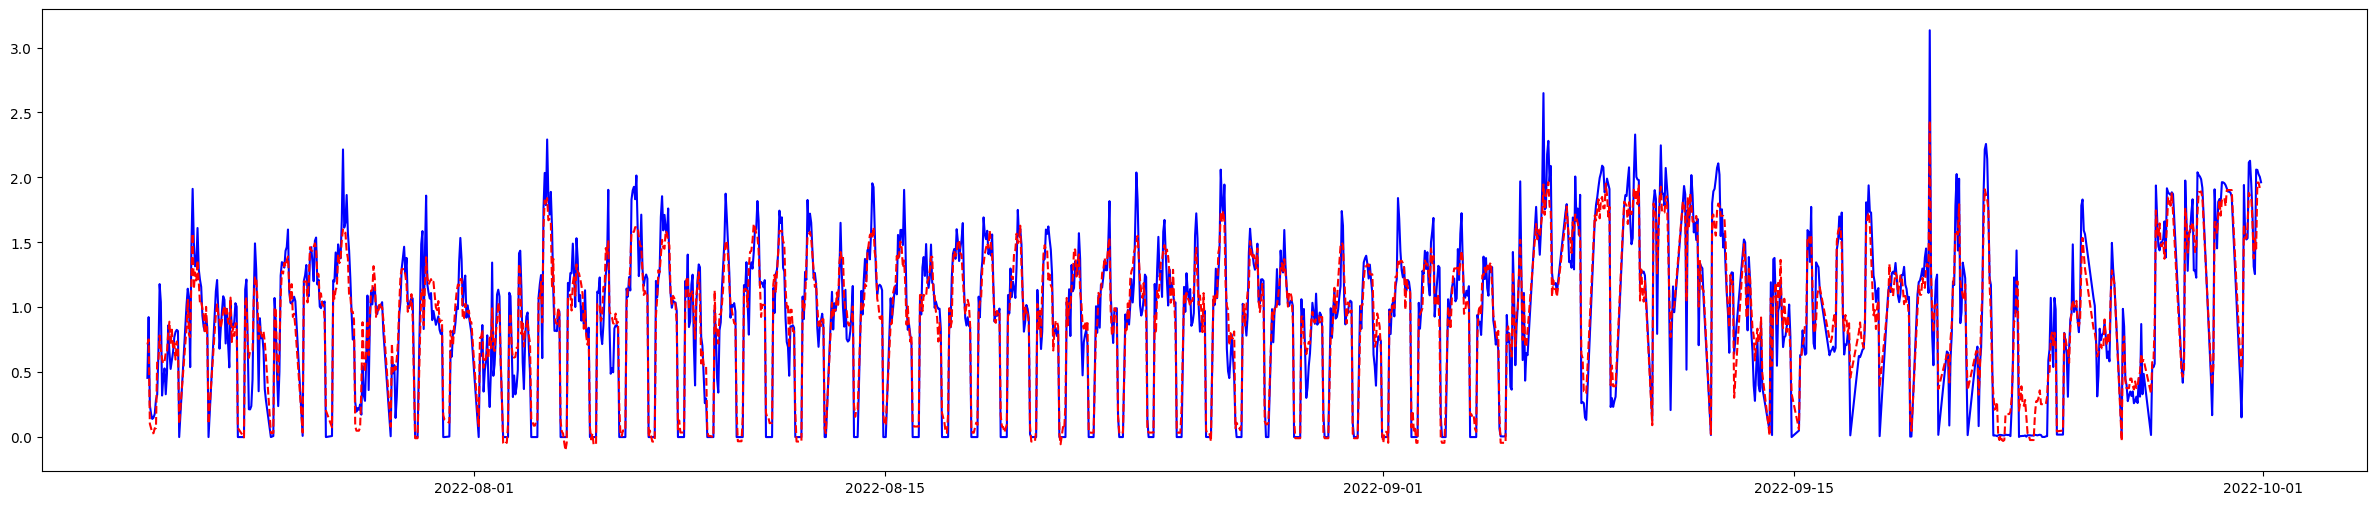

In [30]:
from sklearn.metrics import mean_absolute_error

predict_data['predicted_power_XGBGrid'] = grid_search.predict(pred_X)
train_data['predicted_power_XGBGrid'] = grid_search.predict(X)

mse = mean_squared_error(predict_data['power'], predict_data['predicted_power_XGBGrid'])
mae = mean_absolute_error(predict_data['power'], predict_data['predicted_power_XGBGrid'])
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


plt.figure(figsize=(10, 6))
plt.plot(predict_data['datetime'], predict_data['power'], label='Actual Power', color='blue')
plt.plot(predict_data['datetime'], predict_data['predicted_power_XGBGrid'], label='Predicted Power', color='red', linestyle='--')

plt.xlabel('Datetime')
plt.ylabel('Power')
plt.title('Actual vs Predicted Power')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(30, 6))
plt.plot(train_data['datetime'], train_data['power'], label='Actual Power', color='blue')

plt.plot(train_data['datetime'], train_data['predicted_power_XGBGrid'], label='Predicted Power', color='red', linestyle='--' )
plt.show()

train_test_split (Lag data)

In [31]:

feature_columns = top_12_features_lag2['Feature'].values

X = X_train[feature_columns].astype(float).values.tolist()
Y = y_train['power'].astype(float).values.tolist()
pred_X = X_test[feature_columns].astype(float).values.tolist()
pred_Y = y_test['power'].astype(float).values.tolist()

In [32]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Apply the scaler to the training data
X_scaled = scaler.fit_transform(X)

# Apply the same scaler to the prediction data
pred_X_scaled = scaler.transform(pred_X)

In [33]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

cv_split = TimeSeriesSplit(n_splits=4, test_size=80)
model = xgb.XGBRegressor()
parameters = {
    "max_depth": [3, 4, 6, 10],
    "eta": [0.01, 0.05, 0.1, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7],
    "subsample":[0.8,0.9,1.0],
    "gamma": [0,0.2,0.4,0.6]
}
grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters,n_jobs = -1)
grid_search.fit(X_scaled, Y)
print("Best parameters found: ", grid_search.best_params_)


Best parameters found:  {'colsample_bytree': 0.7, 'eta': 0.05, 'gamma': 0, 'max_depth': 6, 'n_estimators': 1000, 'subsample': 0.9}


In [34]:
# grid_search = xgb.XGBRegressor(colsample_bytree = 0.7, eta= 0.05, gamma= 0, max_depth= 6, n_estimators= 1000, subsample= 0.9)
# grid_search.fit(X_scaled,Y)
mse = mean_squared_error(y_test['power'].astype(float).values.tolist(), grid_search.predict(pred_X_scaled))
mae = mean_absolute_error(y_test['power'].astype(float).values.tolist(), grid_search.predict(pred_X_scaled))

print(mse)
print(mae)


0.06471034330406226
0.19191753354467864


Cut off date (Lag data)

In [35]:
feature_columns = top_12_features_lag['Feature'].values
X, Y = prepare_data(train_data, feature_columns, target)
pred_X, pred_Y = prepare_data(predict_data,feature_columns,target)
scaler = StandardScaler()

# Apply the scaler to the training data
X_scaled = scaler.fit_transform(X)

# Apply the same scaler to the prediction data
pred_X_scaled = scaler.transform(pred_X)

In [36]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

cv_split = TimeSeriesSplit(n_splits=4, test_size=80)
model = xgb.XGBRegressor()
parameters = {
    "max_depth": [3, 4, 6, 10],
    "eta": [0.01, 0.05,0.1,0.3],
    "n_estimators": [100, 300, 500, 700,900,1000],
    "colsample_bytree": [0.3, 0.5, 0.7],
    "subsample":[0.8,0.9,1.0],
    "gamma": [0,0.2,0.4,0.6]
}
grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters,n_jobs = -1)
grid_search.fit(X_scaled, Y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=80),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impor...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'eta': [0.01, 0.05, 0.1, 0.3],
                         'gamma': [0, 0.2, 0.4, 0.6],
                         'max_depth': [3, 4, 6, 10],
                         'n_estimators': [100, 300, 500, 700, 900, 1000],
                         'subsample': [0.8, 0.9, 1.0]})

In [37]:
print("Best parameters found: ", grid_search.best_params_)



Best parameters found:  {'colsample_bytree': 0.3, 'eta': 0.01, 'gamma': 0.6, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.9}


Mean Squared Error: 0.13510965538108052
Mean Absolute Error: 0.28327631568533984


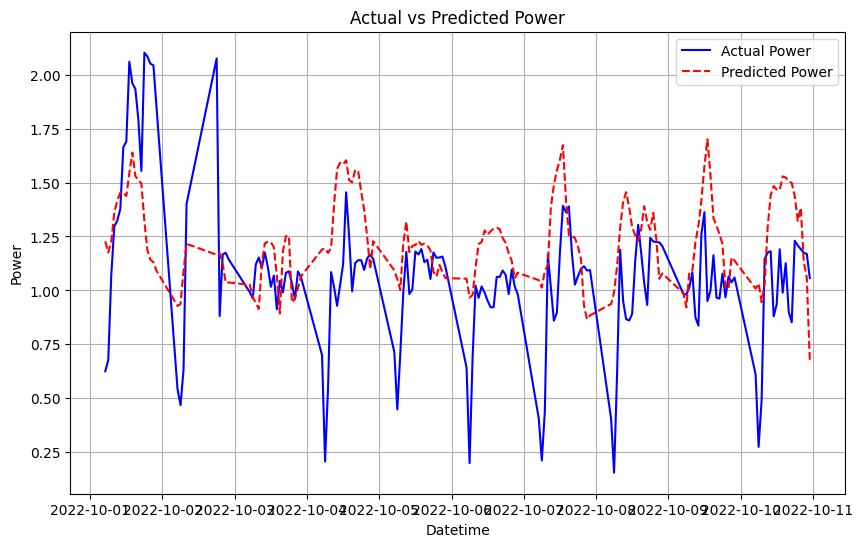

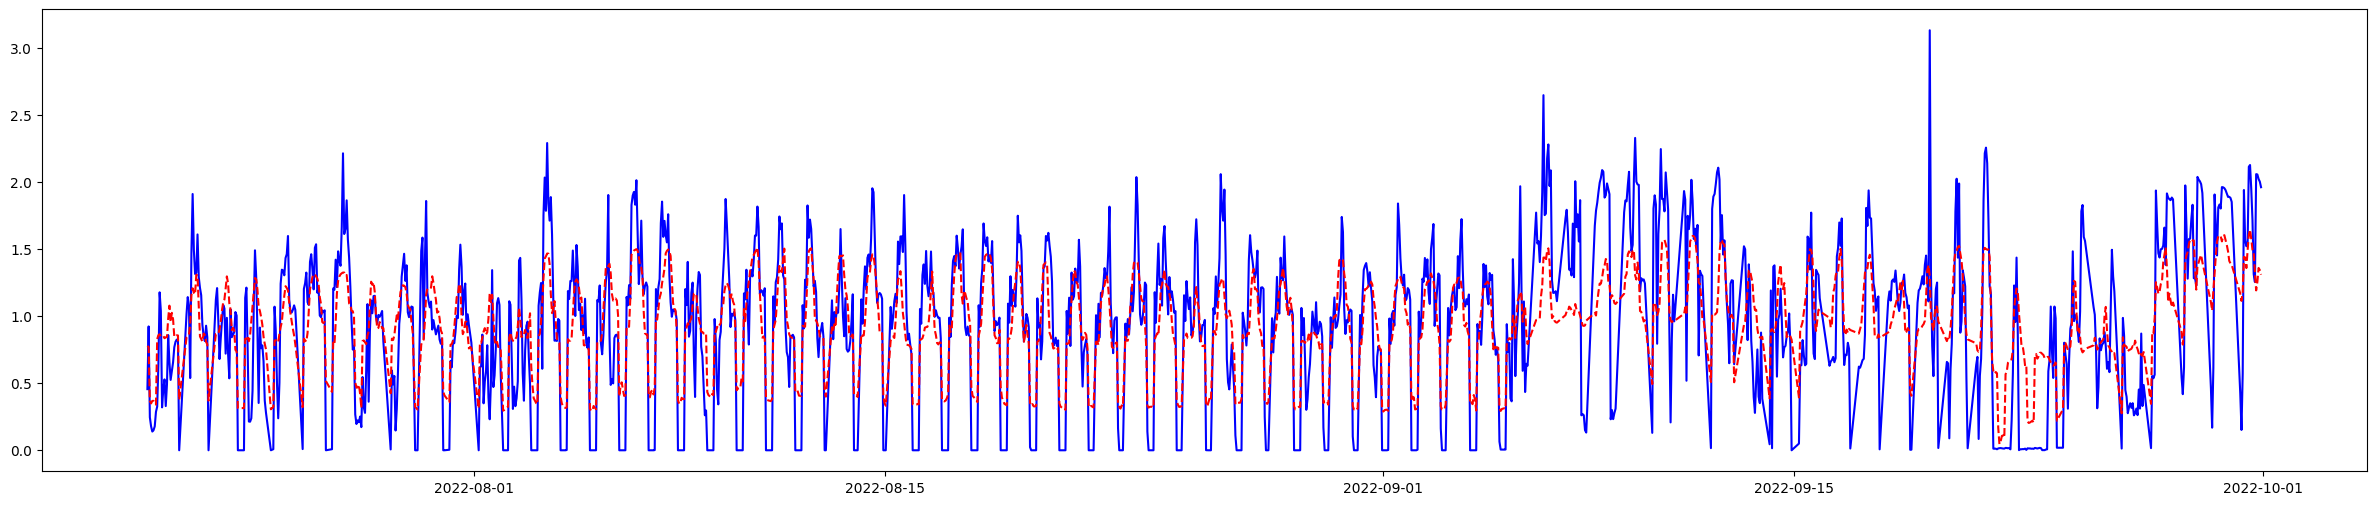

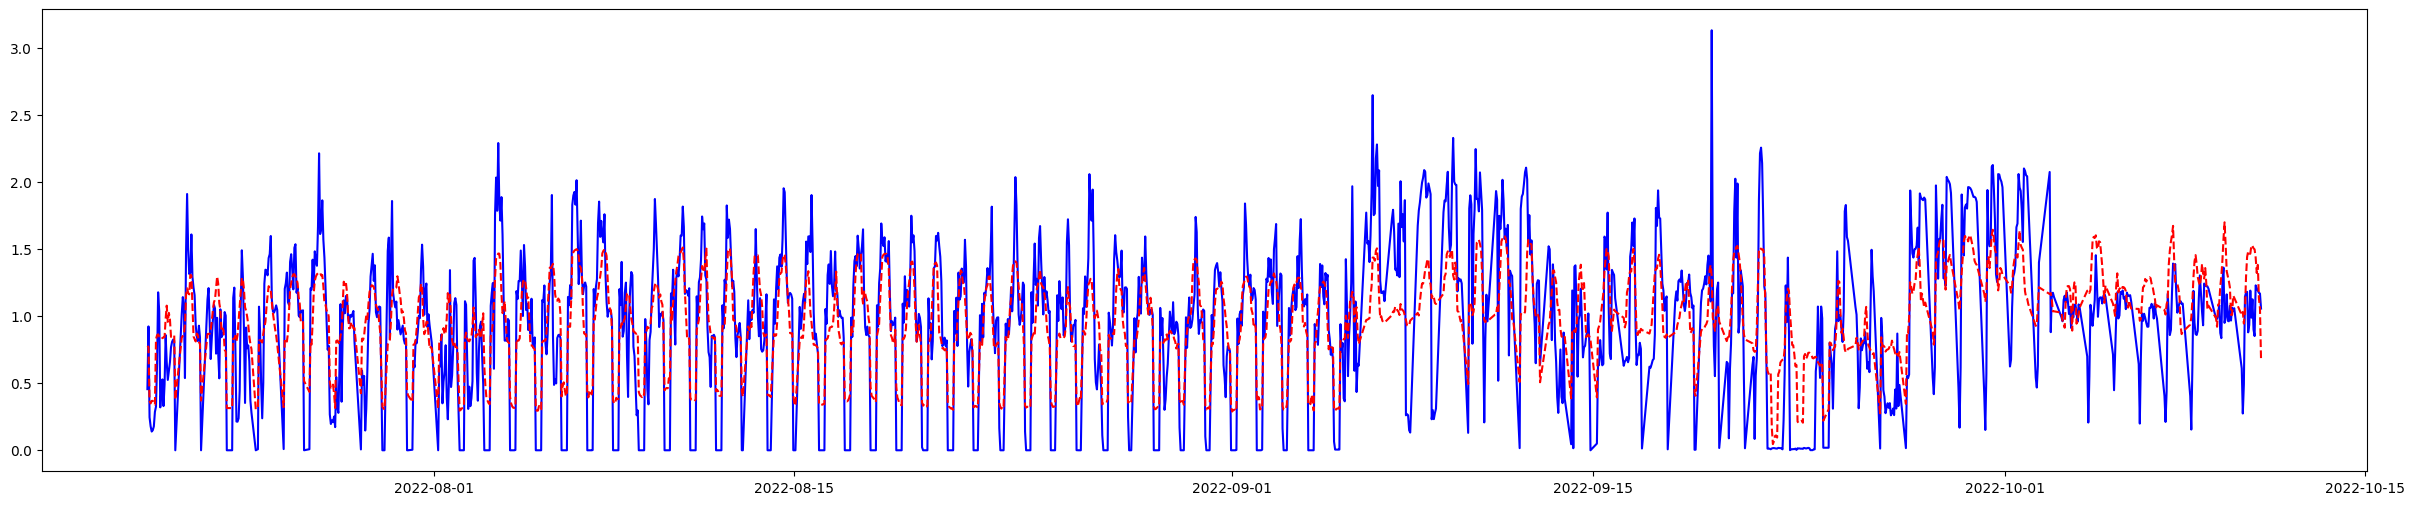

In [38]:
from sklearn.metrics import mean_absolute_error

predict_data['predicted_power_XGBGrid'] = grid_search.predict(pred_X_scaled)
train_data['predicted_power_XGBGrid'] = grid_search.predict(X_scaled)

mse = mean_squared_error(predict_data['power'], predict_data['predicted_power_XGBGrid'])
mae = mean_absolute_error(predict_data['power'], predict_data['predicted_power_XGBGrid'])
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


plt.figure(figsize=(10, 6))
plt.plot(predict_data['datetime'], predict_data['power'], label='Actual Power', color='blue')
plt.plot(predict_data['datetime'], predict_data['predicted_power_XGBGrid'], label='Predicted Power', color='red', linestyle='--')

plt.xlabel('Datetime')
plt.ylabel('Power')
plt.title('Actual vs Predicted Power')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(30, 6))
plt.plot(train_data['datetime'], train_data['power'], label='Actual Power', color='blue')

plt.plot(train_data['datetime'], train_data['predicted_power_XGBGrid'], label='Predicted Power', color='red', linestyle='--' )
plt.show()
test =data[data['datetime'] < '2022-10-11']
test_X, test_Y = prepare_data(test,feature_columns,target)
test['predicted_power_XGBGrid'] = grid_search.predict(scaler.transform(test_X))



plt.figure(figsize=(30, 6))
plt.plot(test['datetime'], test['power'], label='Actual Power', color='blue')

plt.plot(test['datetime'], test['predicted_power_XGBGrid'], label='Predicted Power', color='red', linestyle='--' )
plt.show()


SVR

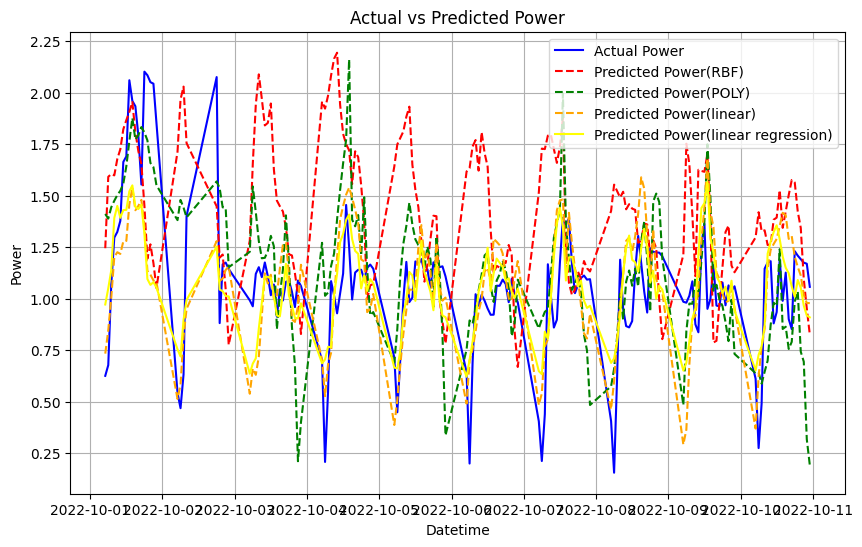

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
 
X = train_data[top_12_features_lag['Feature'].values]
Y = train_data['power']
scaler = StandardScaler().fit(X)
X_train_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(predict_data[top_12_features_lag['Feature'].values])

svr_poly = SVR(kernel = 'poly')
svr_poly.fit(X_train_scaled, Y)
predict_data['predicted_power_SVR_poly'] = svr_poly.predict(X_test_scaled)

svr_rbf = SVR(kernel = 'rbf')
svr_rbf.fit(X_train_scaled, Y)
predict_data['predicted_power_SVR_rbf'] = svr_rbf.predict(X_test_scaled)

svr_linear = SVR(kernel = 'linear')
svr_linear.fit(X_train_scaled, Y)
predict_data['predicted_power_SVR_linear'] = svr_linear.predict(X_test_scaled)


plt.figure(figsize=(10, 6))
plt.plot(predict_data['datetime'], predict_data['power'], label='Actual Power', color='blue')
plt.plot(predict_data['datetime'], predict_data['predicted_power_SVR_rbf'], label='Predicted Power(RBF)', color='red', linestyle='--')
plt.plot(predict_data['datetime'], predict_data['predicted_power_SVR_poly'], label='Predicted Power(POLY)', color='green', linestyle='--')
plt.plot(predict_data['datetime'], predict_data['predicted_power_SVR_linear'], label='Predicted Power(linear)', color='orange', linestyle='--')
plt.plot(predict_data['datetime'], predict_data['predicted_power'], label='Predicted Power(linear regression)', color='yellow')


plt.xlabel('Datetime')
plt.ylabel('Power')
plt.title('Actual vs Predicted Power')
plt.legend()
plt.grid(True)
plt.show()

svr_models = {
    'poly': svr_poly,
    'rbf': svr_rbf,
    'linear': svr_linear
}

ENSEMBLING

In [40]:

feature_columns = top_12_features_lag2['Feature'].values

X = X_train[feature_columns].astype(float).values.tolist()
Y = y_train['power'].astype(float).values.tolist()
pred_X = X_test[feature_columns].astype(float).values.tolist()
pred_Y = y_test['power'].astype(float).values.tolist()
from sklearn.preprocessing import StandardScaler

all_X = data[feature_columns].astype(float).values.tolist()
scaler = StandardScaler()

# Apply the scaler to the training data
X_scaled = scaler.fit_transform(X)

# Apply the same scaler to the prediction data
pred_X_scaled = scaler.transform(pred_X)

all_X_scaled = scaler.transform(all_X)


In [41]:
weights = np.arange(0.0, 1.05, 0.05)

# Initialize variables to store the best combination of weights and its corresponding error
best_mse = float('inf')
best_mae = float('inf')
best_weights = None

grid_search = xgb.XGBRegressor(colsample_bytree = 0.7, eta= 0.05, gamma= 0, max_depth= 6, n_estimators= 1000, subsample= 0.9)
grid_search.fit(X_scaled,Y)
y_test['predicted_power_XGB'] = grid_search.predict(pred_X_scaled)
data['predicted_power_XGB'] = grid_search.predict(all_X_scaled)
X = train_data[top_6_features['Feature'].values]
Y = train_data['power']
regr = linear_model.LinearRegression()
regr.fit(X, Y)
data['predicted_power'] = regr.predict(data[top_6_features['Feature'].values])
y_test['predicted_power'] = regr.predict(X_test[top_6_features['Feature'].values])

X = train_data[top_12_features_lag['Feature'].values]
scaler = StandardScaler().fit(X)
X_train_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(predict_data[top_12_features_lag['Feature'].values])

# Iterate through all possible combinations of weights and kernel
for ker in ['poly','rbf','linear']:
    for w1 in weights:
        for w2 in weights:
            for w3 in weights:
                if np.isclose(w1 + w2 + w3, 1.0):  # Ensure the weights sum to 1
                    # Calculate the weighted sum
                    y_test[f'predicted_power_{ker}'] = svr_models[ker].predict(scaler.transform(X_test[top_12_features_lag['Feature'].values]))
                    y_test['final'] = w1 * y_test['predicted_power_XGB'] + w2 * y_test['predicted_power'] + w3 * y_test[f'predicted_power_{ker}']
                    
                    # Calculate the MSE and MAE
                    mse = mean_squared_error(y_test['power'], y_test['final'])
                    mae = mean_absolute_error(y_test['power'], y_test['final'])
                    
                    # Update the best weights and error if current combination is better
                    if mse < best_mse:
                        best_mse = mse
                        best_mae = mae
                        best_weights = (ker,w1, w2, w3)
print(best_weights)
print(f"best mse: {best_mse}")
print(f"best_mae: {best_mae}")


('rbf', 0.9500000000000001, 0.0, 0.05)
best mse: 0.06426628652136578
best_mae: 0.1917850072536418


In [53]:
from sklearn.linear_model import Ridge
X = train_data[top_6_features['Feature'].values]
Y = train_data['power']
regr = Ridge()
regr.fit(X, Y)

coefficients = regr.coef_  
intercept = regr.intercept_  

print("Coefficients:", coefficients)
print("Intercept:", intercept)

data['Ridge'] = regr.predict(data[top_6_features['Feature'].values])



Coefficients: [ 0.01430911  0.00544815 -0.02374617  0.03786101 -0.00212149  0.01173758]
Intercept: 0.3040625859241515


In [54]:
from sklearn.linear_model import Lasso

regr = Lasso(alpha=0.3)
regr.fit(X,Y)
data['Lasso'] = regr.predict(data[top_6_features['Feature'].values])


In [55]:
data['predicted_power_SVR_rbf'] = svr_models['rbf'].predict(scaler.transform(data[top_12_features_lag['Feature'].values]))
data['predicted_power_SVR_poly'] = svr_models['poly'].predict(scaler.transform(data[top_12_features_lag['Feature'].values]))
data['predicted_power_SVR_linear'] = svr_models['linear'].predict(scaler.transform(data[top_12_features_lag['Feature'].values]))


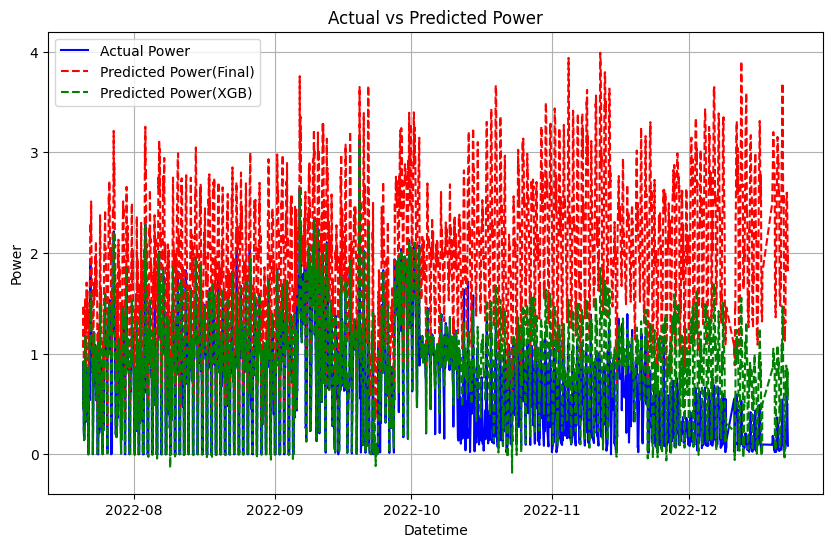

In [43]:
data['final'] = best_weights[1]*data['predicted_power_XGB'] + best_weights[1]*data['predicted_power'] + best_weights[2]*data['predicted_power_SVR_rbf']
# mse = mean_squared_error(predict_data['power'], predict_data['final'])
# mae = mean_absolute_error(predict_data['power'], predict_data['final'])
# print(f'Mean Squared Error: {mse}')
# print(f'Mean Absolute Error: {mae}')


plt.figure(figsize=(10, 6))
plt.plot(data['datetime'], data['power'], label='Actual Power', color='blue')
plt.plot(data['datetime'], data['final'], label='Predicted Power(Final)', color='red', linestyle='--')
plt.plot(data['datetime'], data['predicted_power_XGB'], label='Predicted Power(XGB)', color='green', linestyle='--')


plt.xlabel('Datetime')
plt.ylabel('Power')
plt.title('Actual vs Predicted Power')
plt.legend()
plt.grid(True)
plt.show()

Question 2

In [56]:
#data[['datetime','power','predicted_power','Ridge','Lasso','predicted_power_XGB', 'predicted_power_SVR_rbf','predicted_power_SVR_poly','predicted_power_SVR_linear','final']].to_csv('done.csv', index=False) 

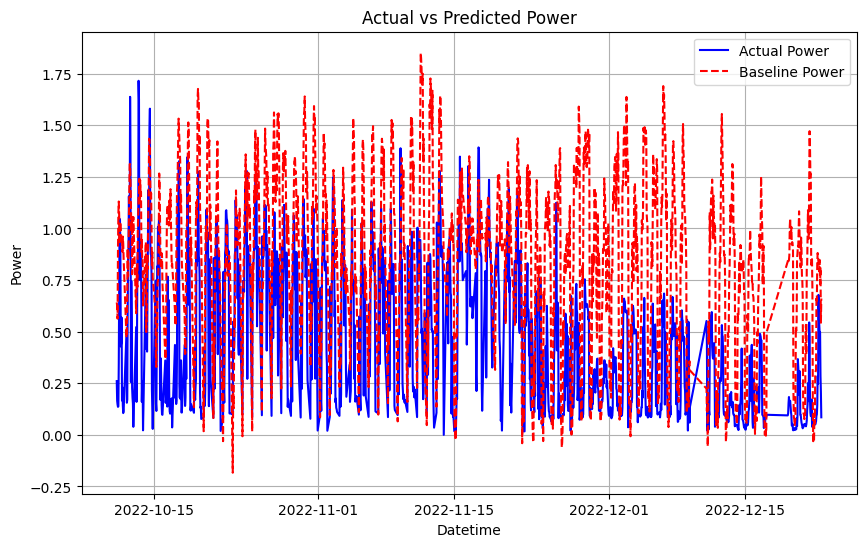

         power  predicted_power_XGB
1695  0.260382             0.641531
1696  0.164741             0.624948
1697  0.146767             0.562879
1698  0.135750             0.886582
1699  0.137883             1.070884
...        ...                  ...
3109  0.492374             0.847204
3110  0.496741             0.730025
3111  0.285893             0.811999
3112  0.207950             0.543041
3113  0.085027             0.660514

[1419 rows x 2 columns]


In [44]:
afteraltozero = data[data['datetime'] >= '2022-10-11']
plt.figure(figsize=(10, 6))
plt.plot(afteraltozero['datetime'], afteraltozero['power'], label='Actual Power', color='blue')
plt.plot(afteraltozero['datetime'], afteraltozero['predicted_power_XGB'], label='Baseline Power', color='red', linestyle='--')

plt.xlabel('Datetime')
plt.ylabel('Power')
plt.title('Actual vs Predicted Power')
plt.legend()
plt.grid(True)
plt.show()

print(afteraltozero[['power','predicted_power_XGB']])

In [45]:
afteraltozero['predicted_energy'] = afteraltozero['predicted_power_XGB']
afteraltozero['predicted_energy_lower_bound'] = afteraltozero['predicted_power_XGB'] - 0.1919175
afteraltozero['predicted_energy_upper_bound'] = afteraltozero['predicted_power_XGB'] + 0.1919175
print(afteraltozero[['predicted_energy','predicted_energy_lower_bound','predicted_energy_upper_bound']])

      predicted_energy  predicted_energy_lower_bound  \
1695          0.641531                      0.449613   
1696          0.624948                      0.433031   
1697          0.562879                      0.370961   
1698          0.886582                      0.694665   
1699          1.070884                      0.878966   
...                ...                           ...   
3109          0.847204                      0.655286   
3110          0.730025                      0.538108   
3111          0.811999                      0.620081   
3112          0.543041                      0.351124   
3113          0.660514                      0.468597   

      predicted_energy_upper_bound  
1695                      0.833448  
1696                      0.816866  
1697                      0.754796  
1698                      1.078500  
1699                      1.262801  
...                            ...  
3109                      1.039121  
3110                      0.921

In [46]:
print(f"Energy used after Alto Energy Zero: {afteraltozero['power'].sum()}")
print(f"Predicted baseline energy: {afteraltozero['predicted_energy'].sum()}")
print(f"Predicted baseline energy(Lower bound): {afteraltozero['predicted_energy_lower_bound'].sum()}")
print(f"Predicted baseline energy(Upper bound): {afteraltozero['predicted_energy_upper_bound'].sum()}")



Energy used after Alto Energy Zero: 652.5787250788429
Predicted baseline energy: 1240.90625
Predicted baseline energy(Lower bound): 968.575439453125
Predicted baseline energy(Upper bound): 1513.2373046875


In [47]:
afteraltozero['cumulative_energy'] = afteraltozero['power'].cumsum()
afteraltozero['cumulative_predicted_energy'] = afteraltozero['predicted_energy'].cumsum()
afteraltozero['cumulative_predicted_energy_lower_bound'] = afteraltozero['predicted_energy_lower_bound'].cumsum()
afteraltozero['cumulative_predicted_energy_upper_bound'] = afteraltozero['predicted_energy_upper_bound'].cumsum()

print(afteraltozero[['cumulative_energy','cumulative_predicted_energy','cumulative_predicted_energy_lower_bound','cumulative_predicted_energy_upper_bound']])


      cumulative_energy  cumulative_predicted_energy  \
1695           0.260382                     0.641531   
1696           0.425124                     1.266479   
1697           0.571890                     1.829358   
1698           0.707640                     2.715940   
1699           0.845524                     3.786824   
...                 ...                          ...   
3109         651.503113                  1238.161377   
3110         651.999854                  1238.891357   
3111         652.285748                  1239.703369   
3112         652.493698                  1240.246460   
3113         652.578725                  1240.906982   

      cumulative_predicted_energy_lower_bound  \
1695                                 0.449613   
1696                                 0.882644   
1697                                 1.253605   
1698                                 1.948270   
1699                                 2.827236   
...                              

In [631]:
#afteraltozero[['datetime','power','predicted_energy','cumulative_energy','cumulative_predicted_energy','cumulative_predicted_energy_lower_bound','cumulative_predicted_energy_upper_bound']].to_csv('savings.csv', index=False) 

In [51]:
num_days = data['datetime'].dt.date.nunique()

# Calculate the total number of hours
total_hours = len(data)

# Calculate the average hours per day
average_hours_per_day = total_hours / num_days

print(average_hours_per_day)

20.22077922077922


END (Below is some misc.)

In [623]:
df = pd.read_csv('energy_data.csv')

df = df.dropna(subset=['energy'])

# Remove rows with negative power
df = df[df['power'] >= 0]
raw_data = df.copy()
raw_data['datetime'] = pd.to_datetime(raw_data['datetime'])
raw_data = raw_data.sort_values(by='datetime').reset_index()
raw_data = raw_data.drop("index", axis=1)
print(raw_data)

energy = {"AC1":0,"AC2":0,"AC3":0,"AC4":0}

                  datetime device_id  power    energy
0      2022-07-20 21:45:32       AC2  0.000     0.112
1      2022-07-20 21:45:33       AC4  0.000     0.028
2      2022-07-20 21:45:33       AC3  0.000     0.025
3      2022-07-20 21:49:38       AC2  0.086     0.113
4      2022-07-20 21:49:39       AC4  0.000     0.029
...                    ...       ...    ...       ...
249032 2022-12-22 20:19:51       AC1  0.143  1435.171
249033 2022-12-22 20:19:57       AC4  0.022   213.126
249034 2022-12-22 20:20:51       AC1  0.144  1435.174
249035 2022-12-22 20:21:03       AC4  0.023   213.126
249036 2022-12-22 20:23:51       AC1  0.146  1435.181

[249037 rows x 4 columns]


In [624]:
for index, row in raw_data.iterrows():
    device = row['device_id']
    new_energy = row['energy']
    if energy[device] < new_energy:
        energy[device] = new_energy
    raw_data.at[index, 'energy'] = sum(energy.values())
print(raw_data)
raw_data = raw_data.drop("power", axis=1)

raw_data = raw_data.loc[raw_data.groupby('datetime')['energy'].idxmax()]
print(raw_data)

                  datetime device_id  power    energy
0      2022-07-20 21:45:32       AC2  0.000     0.112
1      2022-07-20 21:45:33       AC4  0.000     0.140
2      2022-07-20 21:45:33       AC3  0.000     0.165
3      2022-07-20 21:49:38       AC2  0.086     0.166
4      2022-07-20 21:49:39       AC4  0.000     0.167
...                    ...       ...    ...       ...
249032 2022-12-22 20:19:51       AC1  0.143  3232.361
249033 2022-12-22 20:19:57       AC4  0.022  3232.362
249034 2022-12-22 20:20:51       AC1  0.144  3232.365
249035 2022-12-22 20:21:03       AC4  0.023  3232.365
249036 2022-12-22 20:23:51       AC1  0.146  3232.372

[249037 rows x 4 columns]
                  datetime device_id    energy
0      2022-07-20 21:45:32       AC2     0.112
2      2022-07-20 21:45:33       AC3     0.165
3      2022-07-20 21:49:38       AC2     0.166
4      2022-07-20 21:49:39       AC4     0.167
5      2022-07-20 21:50:38       AC2     0.167
...                    ...       ...       

In [625]:
df = pd.DataFrame(data)

raw_data['hour'] = raw_data['datetime'].dt.floor('H')
# Group by the new hour column and calculate the mean energy and count of rows
grouped = raw_data.groupby('hour').agg(mean_energy=('energy', 'mean'), row_count=('energy', 'size')).reset_index()
print(grouped)

                    hour  mean_energy  row_count
0    2022-07-20 21:00:00     0.212765         17
1    2022-07-20 22:00:00     1.426280         75
2    2022-07-20 23:00:00     2.469133         75
3    2022-07-21 00:00:00     2.673867         60
4    2022-07-21 01:00:00     2.851559         59
...                  ...          ...        ...
3109 2022-12-22 16:00:00  3230.354104        115
3110 2022-12-22 17:00:00  3231.017824        108
3111 2022-12-22 18:00:00  3231.727773         75
3112 2022-12-22 19:00:00  3232.144356        101
3113 2022-12-22 20:00:00  3232.331541         37

[3114 rows x 3 columns]


In [626]:
print(grouped['hour'].iloc[50:100])

50   2022-07-23 09:00:00
51   2022-07-23 10:00:00
52   2022-07-23 11:00:00
53   2022-07-23 12:00:00
54   2022-07-23 13:00:00
55   2022-07-23 14:00:00
56   2022-07-23 15:00:00
57   2022-07-23 16:00:00
58   2022-07-23 17:00:00
59   2022-07-23 18:00:00
60   2022-07-23 19:00:00
61   2022-07-23 20:00:00
62   2022-07-23 21:00:00
63   2022-07-23 22:00:00
64   2022-07-23 23:00:00
65   2022-07-24 04:00:00
66   2022-07-24 05:00:00
67   2022-07-24 06:00:00
68   2022-07-24 07:00:00
69   2022-07-24 08:00:00
70   2022-07-24 09:00:00
71   2022-07-24 10:00:00
72   2022-07-24 11:00:00
73   2022-07-24 12:00:00
74   2022-07-24 13:00:00
75   2022-07-24 14:00:00
76   2022-07-24 15:00:00
77   2022-07-24 16:00:00
78   2022-07-24 17:00:00
79   2022-07-24 18:00:00
80   2022-07-24 19:00:00
81   2022-07-24 20:00:00
82   2022-07-24 21:00:00
83   2022-07-24 22:00:00
84   2022-07-25 02:00:00
85   2022-07-25 04:00:00
86   2022-07-25 05:00:00
87   2022-07-25 06:00:00
88   2022-07-25 07:00:00
89   2022-07-25 08:00:00


In [627]:
start = grouped.loc[1694, 'mean_energy']
print(start)

2216.528761904762


In [628]:
print(grouped.iloc[1695:])

                    hour  mean_energy  row_count
1695 2022-10-11 05:00:00  2217.431735         68
1696 2022-10-11 06:00:00  2217.650276         58
1697 2022-10-11 07:00:00  2217.813250         60
1698 2022-10-11 08:00:00  2217.946067         60
1699 2022-10-11 09:00:00  2218.081167         60
...                  ...          ...        ...
3109 2022-12-22 16:00:00  3230.354104        115
3110 2022-12-22 17:00:00  3231.017824        108
3111 2022-12-22 18:00:00  3231.727773         75
3112 2022-12-22 19:00:00  3232.144356        101
3113 2022-12-22 20:00:00  3232.331541         37

[1419 rows x 3 columns]
